# TECHNICAL APPENDIX
#### Note that the code is limited to the modelling part of the analysis. A lot of data preprocessing and exploratory data analysis was done prior to selecting the final dataset. The entire code is not shown because of the space limitations. Also, as the analysis for delay is very similar, only the best model output is shown.
### Flight Dataset
We will use the flight dataset to predict delays and cancellations. The code is divided into three parts. 

1.   Common data preprocessing
2.   Data preprocessing for cancellations and cancellation prediction
3.   Data preprocessing for delays and delay prediction.

### The data description of the dataset is given below.
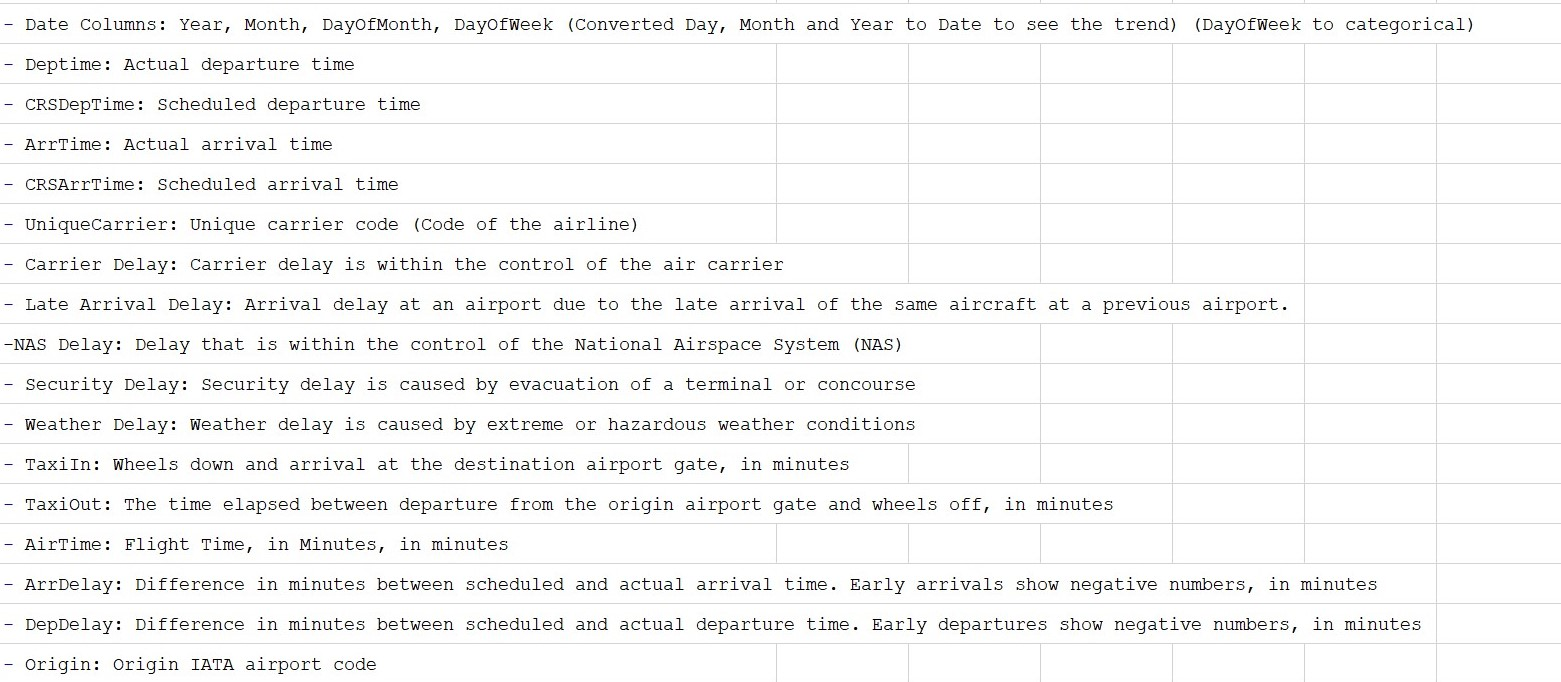



#### SECTION 1: LOADING DATA AND INITIAL PREPROCESSING

In [ ]:
#Importing important packages
import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from datetime import date
#Data preprocessing libraries
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
#Cross validation libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#Modelling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from thundersvm import SVC
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
#Evaluation libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
#Setting options 
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
#Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Mounting the drive and loading data
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#The flight data is just for LGA origin
flight = pd.read_csv('drive/MyDrive/flight.csv')
#Data with aircraft information
plane_data = pd.read_csv('drive/MyDrive/Predictive_Project/plane-data.csv')

Mounted at /content/drive


In [ ]:
def classification_test(y_test, y_test_pred):
  confusion = metrics.confusion_matrix(y_test, y_test_pred)
  TP = confusion[1,1] 
  TN = confusion[0,0] 
  FP = confusion[0,1] 
  FN = confusion[1,0] 
  # Accuracy
  print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))
  # Sensitivity
  print("Sensitivity:-",TP / float(TP+FN))
  # Specificity
  print("Specificity:-", TN / float(TN+FP))
  print("\n\nClassification Report")
  print("\n",classification_report(y_test, y_test_pred))
  sns.heatmap(confusion, annot = True, annot_kws={"size": 16},fmt='g', cmap = 'Purples')
  plt.show()

In [ ]:
flight.drop('Unnamed: 0', axis = 1, inplace = True)
#Making Delay Flag
flight['DepDelayFlag'] = [1 if i>=15 else 0 for i in flight['DepDelay']]

#Dropping records that are diverted
flight = flight[flight.Diverted == 0]

#Dropping unwanted variables
flight.drop(['DepTime', 'ArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'TaxiIn', 
             'TaxiOut', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay','SecurityDelay', 'LateAircraftDelay'], axis = 1, inplace = True)

#Correcting the datatypes
flight.rename(columns = {'DayofMonth':'Day'}, inplace = True)
flight['Date'] = pd.to_datetime(flight[['Year','Month', 'Day']])

flight['DayOfWeek'] = flight['DayOfWeek'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday',
                                               4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'})
flight['Month'] = flight['Month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',
                                      9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
flight['CRSDepTime'] = flight['CRSDepTime']//100
flight['CRSArrTime'] = flight['CRSArrTime']//100

#Deriving variables
us_holidays = holidays.US()
flight['Holiday'] = [1 if i in us_holidays else 0 for i in flight['Date']]
flight.drop('Date', axis = 1, inplace = True)
week = []
for i in flight['Day']:
  if i in range(1,8):
    week.append('Week_1')
  elif i in range(8,15):
    week.append('Week_2')
  elif i in range(15,22):
    week.append('Week_3')
  else:
    week.append('Week_4')
flight['Week'] = week
flight.drop(['Day'], axis = 1, inplace = True)

#Capping the distance variable
flight.Distance[flight.Distance>1750] = 1750

In [ ]:
plane_data.dropna(axis = 0, inplace = True)
plane_data.head()

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
34,N10156,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004
35,N102UW,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998
36,N10323,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986
37,N103US,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999
38,N104UA,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998


In [ ]:
#Merging the plane  
plane_data = plane_data[['tailnum', 'type', 'aircraft_type', 'engine_type']]
plane_data.columns = ['TailNum', 'Manufacture_type', 'AirCraft_Type', 'Engine_Type']
#Merging the dataframes
flight = pd.merge(flight, plane_data, how = 'left', on = 'TailNum')
flight[['Manufacture_type', 'AirCraft_Type', 'Engine_Type']] = flight[['Manufacture_type', 'AirCraft_Type', 'Engine_Type']].replace(np.nan, 'Not_Available')
flight.drop(['TailNum', 'FlightNum'], axis = 1, inplace = True)

In [ ]:
#Making dummies for prediction
flight = pd.get_dummies(flight, columns = ['Month', 'DayOfWeek', 'UniqueCarrier', 'CRSDepTime', 'CRSArrTime', 'Week', 'Dest'], drop_first=False)
flight = pd.get_dummies(flight, columns = ['Manufacture_type', 'AirCraft_Type', 'Engine_Type'])
flight.drop(['Manufacture_type_Not_Available', 'AirCraft_Type_Not_Available','Engine_Type_Not_Available'], inplace = True, axis = 1)

In [ ]:
#Splitting the train and test data
train = flight[flight.Year == 2007]
test = flight[flight.Year == 2008]
#Dropping Year column
train.drop('Year', axis = 1, inplace = True)
test.drop('Year', axis = 1, inplace = True)

In [ ]:
#USing min max scaler on distance variable
ss = MinMaxScaler()
normalized_data = ss.fit_transform(train[['Distance']].values) #Fitting on train
train[['Distance']] = normalized_data
test[['Distance']] = ss.transform(test[['Distance']]) #Transforming on test

In [ ]:
#Making copy of the data for delay prediction
train_delay = train.copy()
test_delay = test.copy()

### CANCELLATION PREDICTION

In [ ]:
train.drop('DepDelayFlag', axis = 1, inplace = True)
test.drop('DepDelayFlag', axis = 1, inplace = True)

In [ ]:
#USing min max scaler on distance variable
ss = MinMaxScaler()
normalized_data = ss.fit_transform(train[['Distance']].values) #Fitting on train
train[['Distance']] = normalized_data
test[['Distance']] = ss.transform(test[['Distance']]) #Transforming on test

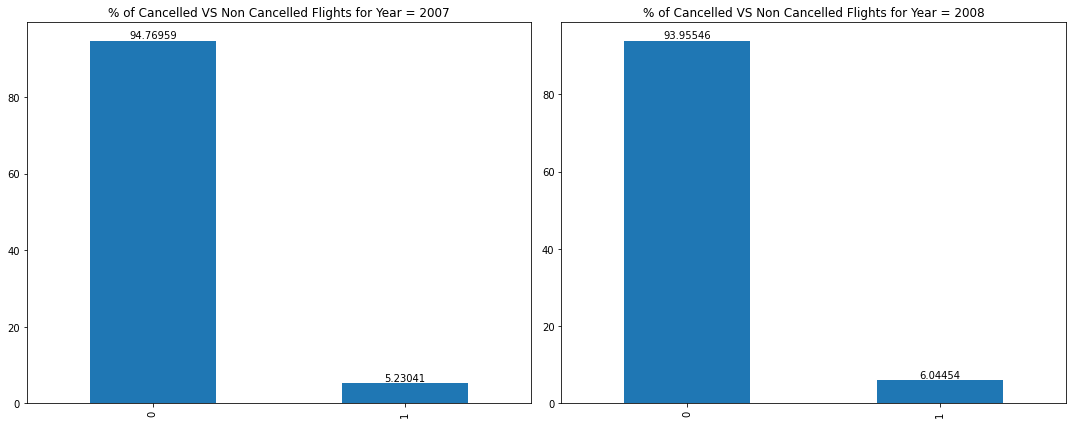

In [ ]:
y_train = train.pop('Cancelled')
X_train = train
y_test = test.pop('Cancelled')
X_test = test

plt.figure(figsize=[15,6])
plt.subplot(121)
plot_bar = (y_train.value_counts(normalize = True)*100).plot.bar()
for p in plot_bar.patches:
  height = p.get_height()
  plot_bar.text(p.get_x()+p.get_width()/2,height+0.5,'{:1.5f}'.format(height), ha = 'center')
plt.title('% of Cancelled VS Non Cancelled Flights for Year = 2007')
plt.subplot(122)
plot_bar = (y_test.value_counts(normalize = True)*100).plot.bar()
for p in plot_bar.patches:
  height = p.get_height()
  plot_bar.text(p.get_x()+p.get_width()/2,height+0.5,'{:1.5f}'.format(height), ha = 'center')
plt.title('% of Cancelled VS Non Cancelled Flights for Year = 2008')
plt.tight_layout()
plt.show()

In [ ]:
smotenc = SMOTENC(random_state=43, sampling_strategy='auto', cat_indx = range(1, X_train.shape[1]))
X_train_smote, y_train_smote = smotenc.fit_resample(X_train, y_train)

In [ ]:
y_train_smote.value_counts()

1    116197
0    116197
Name: Cancelled, dtype: int64

### LOGISTIC REGRESSION

In [ ]:
%%time
param_grid = {"C": np.arange(0.001, 100, 2), 'penalty':['l1', 'l2']}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

search = GridSearchCV(estimator = LogisticRegression(random_state = 43),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    verbose = 1,
                        return_train_score=True) 
results_logistic = search.fit(X_train_smote, y_train_smote)
print('Config: %s' % results_logistic.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Config: {'C': 54.001, 'penalty': 'l2'}
CPU times: user 3min 16s, sys: 6min 7s, total: 9min 24s
Wall time: 1min 12s


Accuracy:- 0.8325845179347425
Sensitivity:- 0.8671811535337124
Specificity:- 0.8303587760328203


Classification Report

               precision    recall  f1-score   support

           0       0.99      0.83      0.90     38269
           1       0.25      0.87      0.39      2462

    accuracy                           0.83     40731
   macro avg       0.62      0.85      0.64     40731
weighted avg       0.94      0.83      0.87     40731



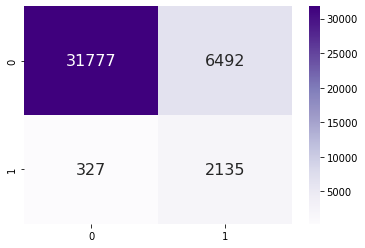

In [ ]:
y_test_pred = results_logistic.predict(X_test)
classification_test(y_test, y_test_pred)

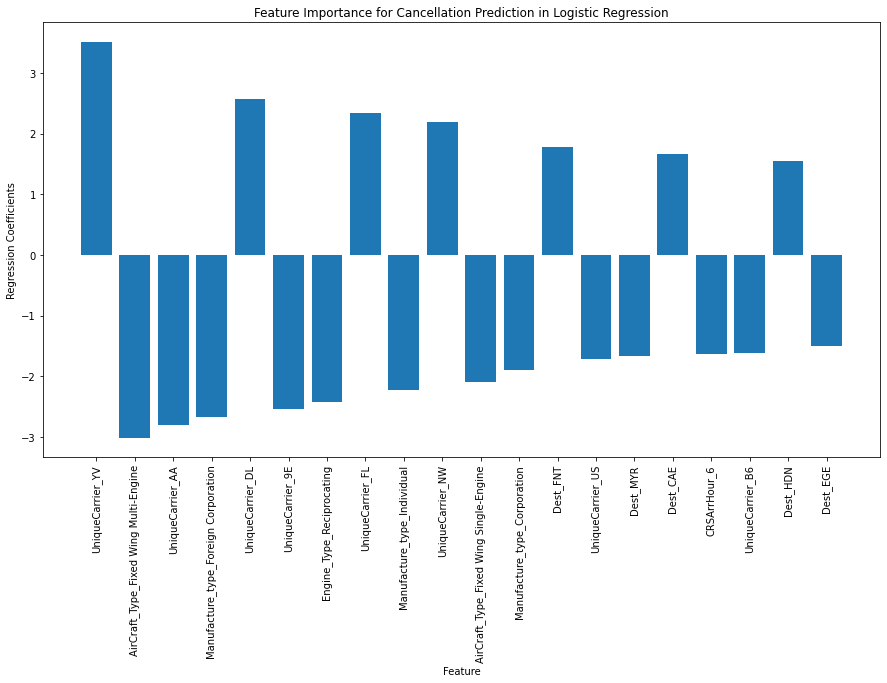

In [ ]:
#Feature Importance
importance = results_logistic.best_estimator_.coef_[0]
feature_importance = {}
i = 0
for feature in X_train.columns:
  feature_importance[feature] = importance[i]
  i += 1
top_20 = {}
for key in sorted(feature_importance, key=lambda x: abs(feature_importance[x]), reverse=True)[:20]:
  top_20[key] = feature_importance[key]

plt.figure(figsize=[15,8])
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation = 90)
plt.title("Feature Importance for Cancellation Prediction in Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("Regression Coefficients")
plt.show()

### Decision Tree

In [ ]:
%%time
param_grid = {
    'max_depth': [2, 5, 10, 15],
    'min_samples_leaf': [5, 10, 50],
    'min_samples_split': [10, 20],
    'criterion' : ['gini', 'entropy'],
    'max_leaf_nodes': [20, 50, 100]
}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


search = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 43, splitter='random'),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 1,
                        return_train_score=True) 
results_decision = search.fit(X_train_smote, y_train_smote)
print('Config: %s' % results_decision.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Config: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}
CPU times: user 51 s, sys: 555 ms, total: 51.5 s
Wall time: 51.3 s


Accuracy:- 0.748201615477155
Sensitivity:- 0.9155158407798538
Specificity:- 0.7374376126891218


Classification Report

               precision    recall  f1-score   support

           0       0.99      0.74      0.85     38269
           1       0.18      0.92      0.31      2462

    accuracy                           0.75     40731
   macro avg       0.59      0.83      0.58     40731
weighted avg       0.94      0.75      0.81     40731



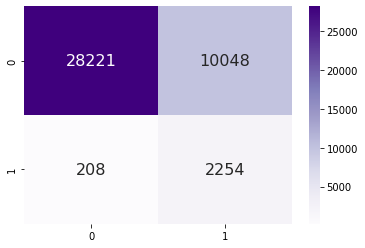

In [ ]:
y_test_pred = results_decision.predict(X_test)
classification_test(y_test, y_test_pred)

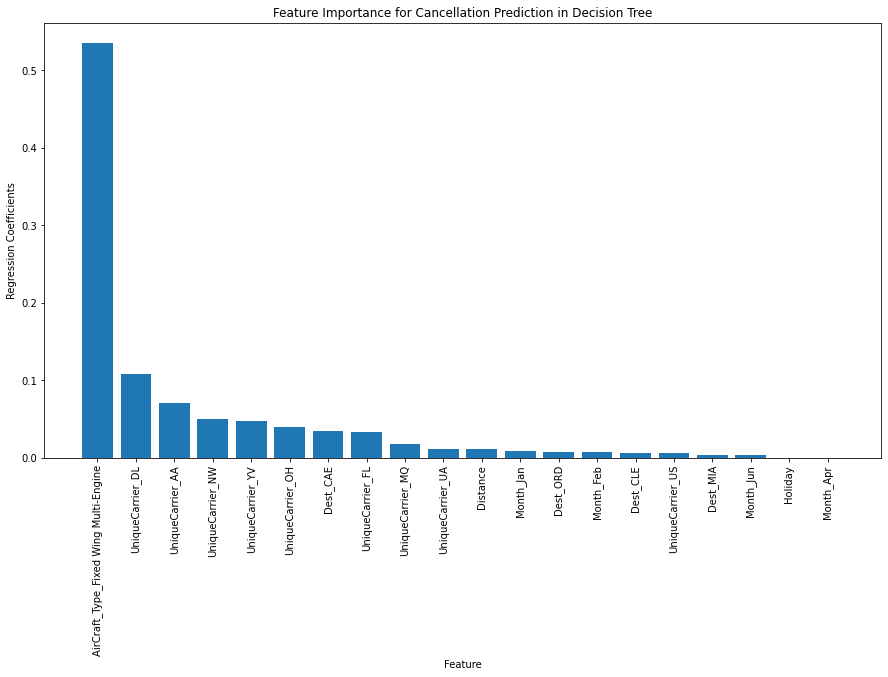

In [ ]:
#Feature Importance
importance = results_decision.best_estimator_.feature_importances_
feature_importance = {}
i = 0
for feature in X_train.columns:
  feature_importance[feature] = importance[i]
  i += 1
top_20 = {}
for key in sorted(feature_importance, key=lambda x: feature_importance[x], reverse=True)[:20]:
  top_20[key] = feature_importance[key]
plt.figure(figsize=[15,8])
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation = 90)
plt.title("Feature Importance for Cancellation Prediction in Decision Tree")
plt.xlabel("Feature")
plt.ylabel("Regression Coefficients")
plt.show()

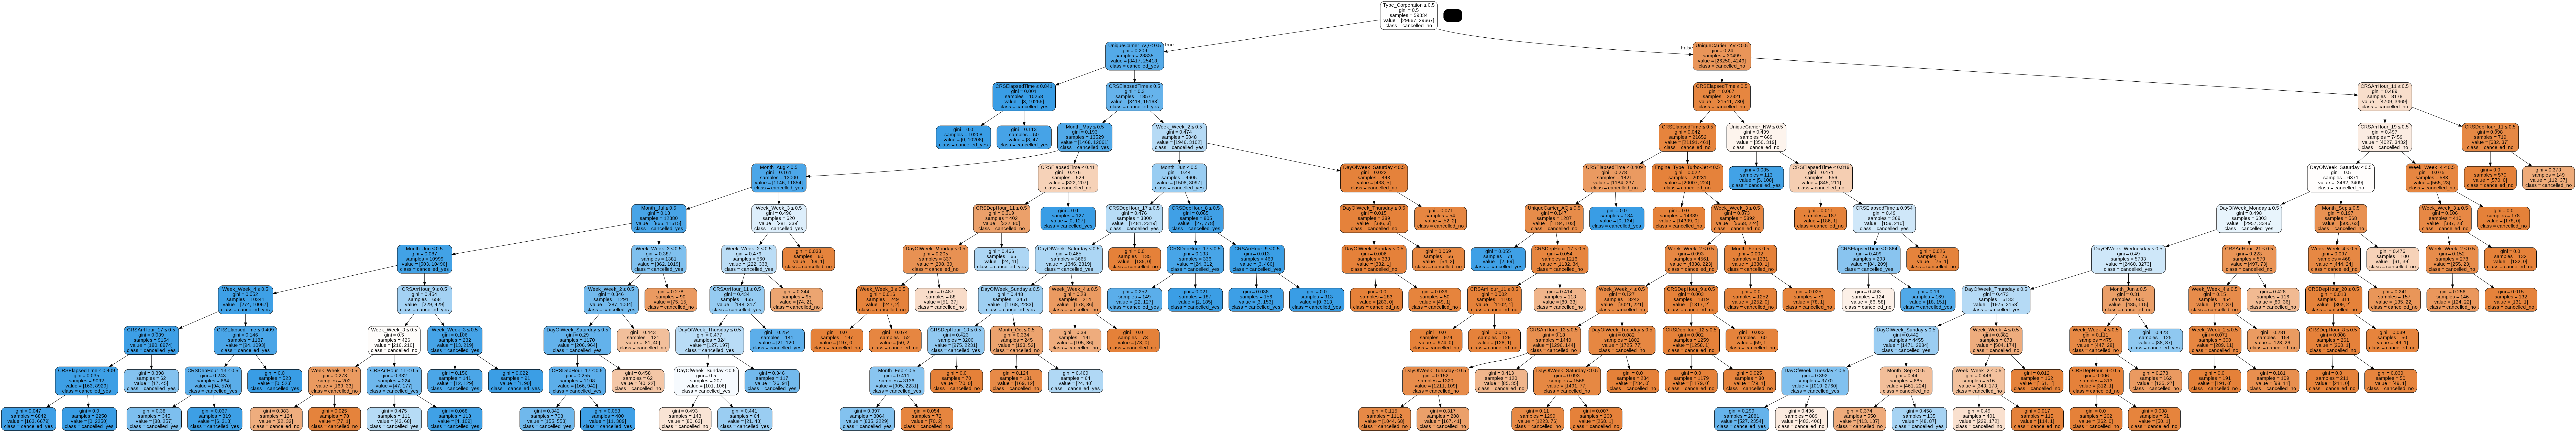

In [ ]:
# create a file to store the figure in
dot_data = StringIO()

export_graphviz(results_decision, out_file=dot_data,  
                filled=True, rounded=True,class_names=['cancelled_no','cancelled_yes'],
                special_characters=True,feature_names=X_train.columns)

# import and display the figure
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Random Forest

In [ ]:
%%time
param_grid = {
    'n_estimators': range(30, 100, 20),
    'max_features' : ['auto', 'sqrt', '0.2'],
    'max_depth' : [ 5, 10, 15, 20],
    'min_samples_leaf' : [20, 50, 100]}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


search = GridSearchCV(estimator = RandomForestClassifier(random_state = 43),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 900,
                        return_train_score=True, n_jobs= -1) 
results_random = search.fit(X_train_smote, y_train_smote)
print('Config: %s' % results_random.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Config: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 20, 'n_estimators': 30}
CPU times: user 6.95 s, sys: 711 ms, total: 7.67 s
Wall time: 51.9 s


Accuracy:- 0.8709336868724068
Sensitivity:- 0.8139723801787165
Specificity:- 0.8745982387833494


Classification Report

               precision    recall  f1-score   support

           0       0.99      0.87      0.93     38269
           1       0.29      0.81      0.43      2462

    accuracy                           0.87     40731
   macro avg       0.64      0.84      0.68     40731
weighted avg       0.94      0.87      0.90     40731



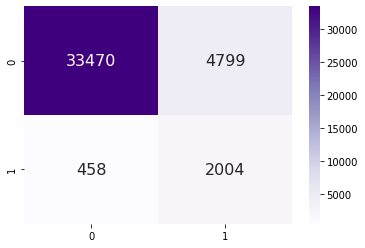

In [ ]:
y_test_pred = results_random.predict(X_test)
classification_test(y_test, y_test_pred)

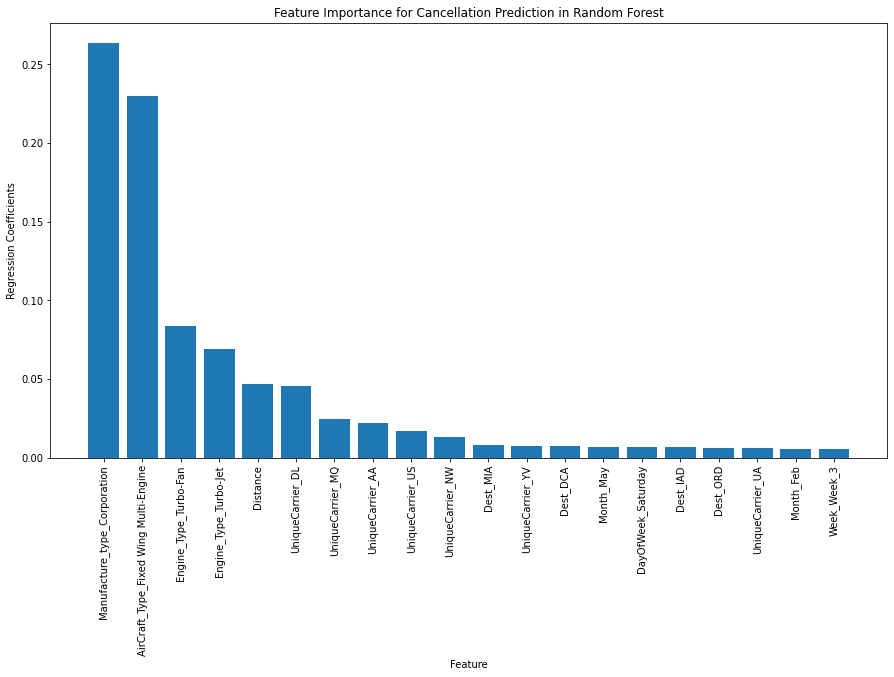

In [ ]:
#Feature Importance
importance = results_random.best_estimator_.feature_importances_
feature_importance = {}
i = 0
for feature in X_train.columns:
  feature_importance[feature] = importance[i]
  i += 1
top_20 = {}
for key in sorted(feature_importance, key=lambda x: feature_importance[x], reverse=True)[:20]:
  top_20[key] = feature_importance[key]

plt.figure(figsize=[15,8])
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation = 90)
plt.title("Feature Importance for Cancellation Prediction in Random Forest")
plt.xlabel("Feature")
plt.ylabel("Regression Coefficients")
plt.show()

### XGBOOST

In [ ]:
%%time
param_grid = {
    'eta' : [0.01, 0.05, 0.1, 0.2],
    'n_estimators': range(20, 100, 20),
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [ 3, 5, 10] ,
}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
gpu_dict = {
    'tree_method': 'gpu_hist'
}

search = GridSearchCV(estimator = XGBClassifier(random_state=43, n_jobs=-1, **gpu_dict, reg_alpha = 50),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 1,
                        return_train_score=True) 
results_xgboost = search.fit(X_train_smote, y_train_smote)
print('Config: %s' % results_xgboost.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Config: {'eta': 0.01, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 60}
CPU times: user 2min 25s, sys: 16.4 s, total: 2min 41s
Wall time: 2min 30s


Accuracy:- 0.8387223490707324
Sensitivity:- 0.8631194151096669
Specificity:- 0.8371527868509759


Classification Report

               precision    recall  f1-score   support

           0       0.99      0.84      0.91     38269
           1       0.25      0.86      0.39      2462

    accuracy                           0.84     40731
   macro avg       0.62      0.85      0.65     40731
weighted avg       0.95      0.84      0.88     40731



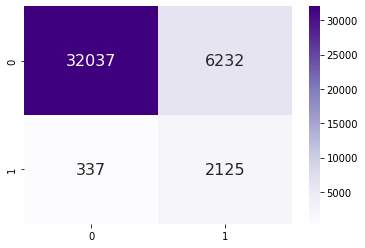

In [ ]:
y_test_pred = results_xgboost.predict(X_test)
classification_test(y_test, y_test_pred)

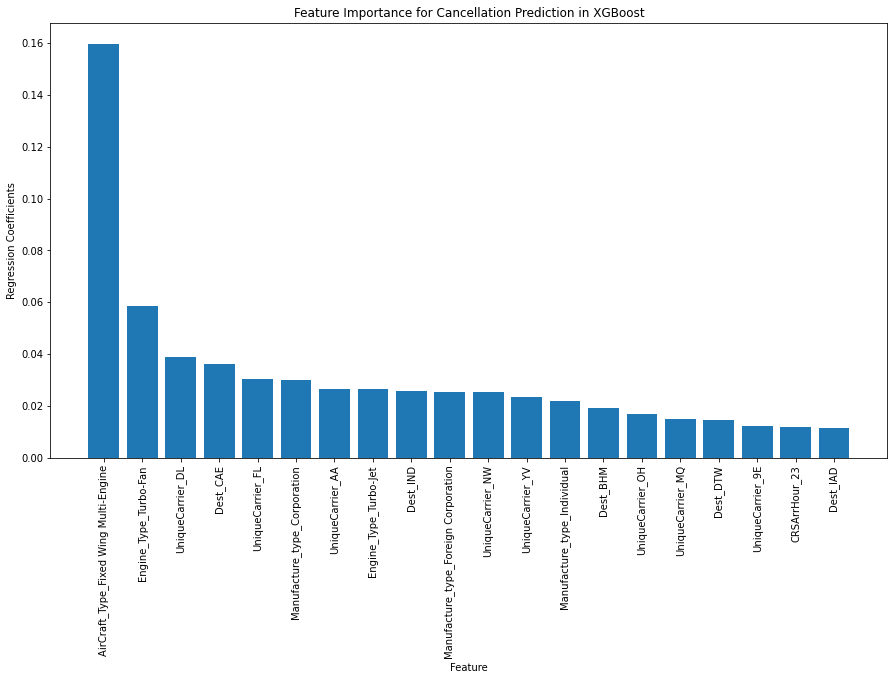

In [ ]:
#Feature Importance
importance = results_xgboost.best_estimator_.feature_importances_
feature_importance = {}
i = 0
for feature in X_train.columns:
  feature_importance[feature] = importance[i]
  i += 1
top_20 = {}
for key in sorted(feature_importance, key=lambda x: feature_importance[x], reverse=True)[:20]:
  top_20[key] = feature_importance[key]

plt.figure(figsize=[15,8])
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation = 90)
plt.title("Feature Importance for Cancellation Prediction in XGBoost")
plt.xlabel("Feature")
plt.ylabel("Regression Coefficients")
plt.show()

### CATBOOST

In [ ]:
%%time
param_grid = {
    'iterations':[100, 200],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'max_depth' : [3, 5, 10] ,
}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


search = GridSearchCV(estimator = CatBoostClassifier(random_state=43, verbose=1),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 1,
                        return_train_score=True, n_jobs=-1) 
results_catboost = search.fit(X_train_smote, y_train_smote)
print('Config: %s' % results_catboost.best_params_)

Accuracy:- 0.8662198325599666
Sensitivity:- 0.8379366368805848
Specificity:- 0.8680394052627453


Classification Report

               precision    recall  f1-score   support

           0       0.99      0.87      0.92     38269
           1       0.29      0.84      0.43      2462

    accuracy                           0.87     40731
   macro avg       0.64      0.85      0.68     40731
weighted avg       0.95      0.87      0.89     40731



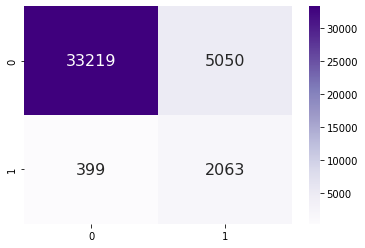

In [ ]:
y_test_pred = results_catboost.predict(X_test)
classification_test(y_test, y_test_pred)

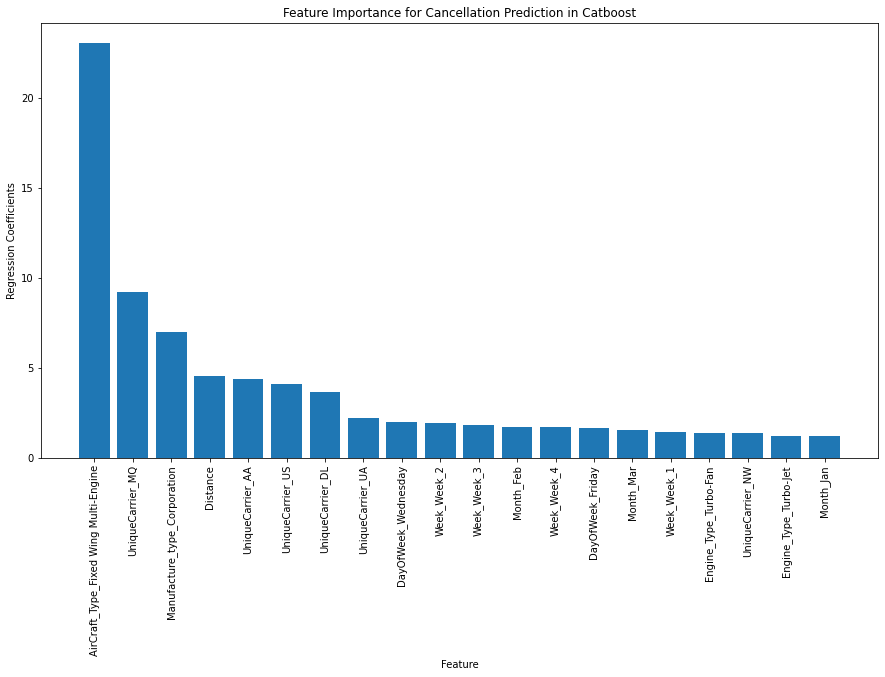

In [ ]:
#Feature Importance
importance = results_catboost.best_estimator_.feature_importances_
feature_importance = {}
i = 0
for feature in X_train.columns:
  feature_importance[feature] = importance[i]
  i += 1
top_20 = {}
for key in sorted(feature_importance, key=lambda x: feature_importance[x], reverse=True)[:20]:
  top_20[key] = feature_importance[key]
plt.figure(figsize=[15,8])
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation = 90)
plt.title("Feature Importance for Cancellation Prediction in Catboost")
plt.xlabel("Feature")
plt.ylabel("Regression Coefficients")
plt.show()

### ADABOOST

In [ ]:
%%time
param_grid = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1]}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


search = GridSearchCV(estimator = AdaBoostClassifier(random_state=43),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 1,
                        return_train_score=True, n_jobs=-1) 
results_adaboost = search.fit(X_train_smote, y_train_smote)
print('Config: %s' % results_adaboost.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Config: {'learning_rate': 0.1, 'n_estimators': 2000}
CPU times: user 36.9 s, sys: 394 ms, total: 37.3 s
Wall time: 4min 33s


Accuracy:- 0.8625862365274607
Sensitivity:- 0.8354995938261576
Specificity:- 0.8643288301235987


Classification Report

               precision    recall  f1-score   support

           0       0.99      0.86      0.92     38269
           1       0.28      0.84      0.42      2462

    accuracy                           0.86     40731
   macro avg       0.64      0.85      0.67     40731
weighted avg       0.95      0.86      0.89     40731



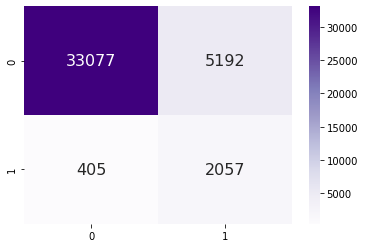

In [ ]:
y_test_pred = results_adaboost.predict(X_test)
classification_test(y_test, y_test_pred)

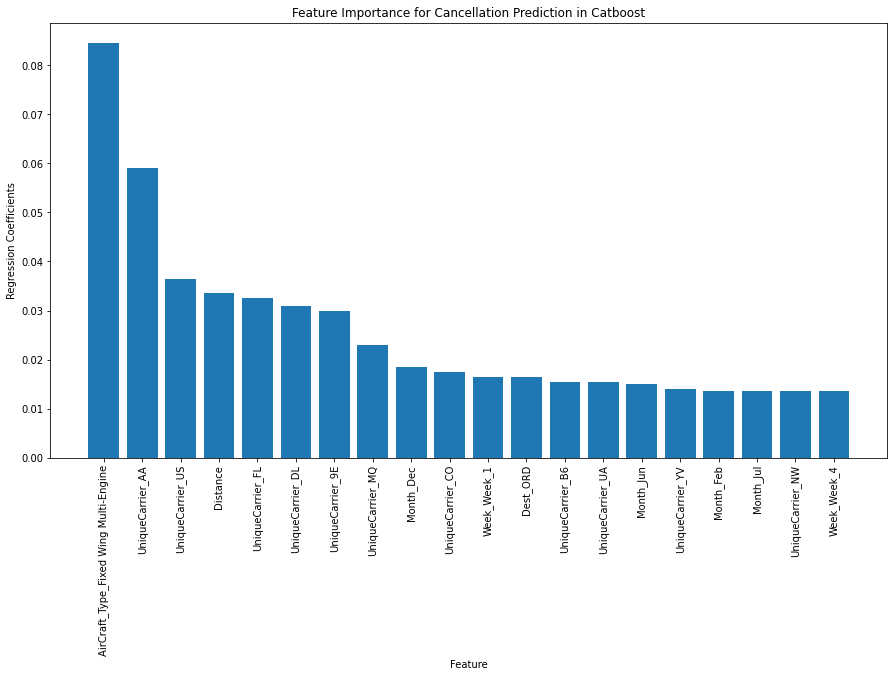

In [ ]:
#Feature Importance
importance = results_adaboost.best_estimator_.feature_importances_
feature_importance = {}
i = 0
for feature in X_train.columns:
  feature_importance[feature] = importance[i]
  i += 1
top_20 = {}
for key in sorted(feature_importance, key=lambda x: feature_importance[x], reverse=True)[:20]:
  top_20[key] = feature_importance[key]
plt.figure(figsize=[15,8])
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation = 90)
plt.title("Feature Importance for Cancellation Prediction in Catboost")
plt.xlabel("Feature")
plt.ylabel("Regression Coefficients")
plt.show()

### SVM

In [ ]:
%%time
param_grid = {'C': np.arange(0.1,1,0.1),
              'gamma': np.arange(0.001,0.01,0.001)}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True)
 
search = GridSearchCV(SVC(n_jobs = -1, probability=True), param_grid, refit = True, verbose = 1, scoring = 'recall', cv = stratified_kfold, return_train_score=True)
 
# fitting the model for grid search
results_svm = search.fit(X_train_smote, y_train_smote)
print('Config: %s' % results_svm.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Config: {'C': 0.9, 'gamma': 0.009000000000000001}
CPU times: user 5min 12s, sys: 21.4 s, total: 5min 34s
Wall time: 5min 31s
Parser   : 249 ms


Accuracy:- 0.7286096584910756
Sensitivity:- 0.9325751421608448
Specificity:- 0.7154877315843111


Classification Report

               precision    recall  f1-score   support

           0       0.99      0.72      0.83     38269
           1       0.17      0.93      0.29      2462

    accuracy                           0.73     40731
   macro avg       0.58      0.82      0.56     40731
weighted avg       0.94      0.73      0.80     40731



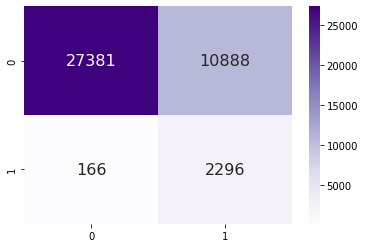

In [ ]:
y_test_pred = results_svm.predict(X_test)
classification_test(y_test, y_test_pred)

### NEURAL NETWORK

In [ ]:
%%time
model = Sequential()
model.add(Dense(50,input_dim=X_train_smote.shape[1]))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(1))

model.add(Activation('sigmoid'))#sigmoid



model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
model.fit(X_train_smote,y_train_smote,epochs=20)
prediction_prob = model.predict(X_test)

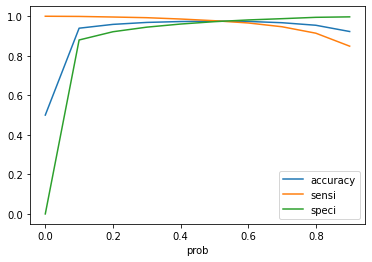

In [ ]:
#Finding optimal threshold
y_train_pred_final = pd.DataFrame(model.predict(X_train_smote), columns = ['Y_train_pred_prob'])
y_train_pred_final['Y_train'] = y_train_smote
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Y_train_pred_prob.map(lambda x: 1 if x > i else 0)
# Calculating accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Y_train, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

# Plotting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
prediction_class = (prediction_prob > 0.58).astype("int32")

Accuracy:- 0.8650168176573126
Sensitivity:- 0.7120227457351747
Specificity:- 0.8748595468917401


Classification Report

               precision    recall  f1-score   support

           0       0.98      0.87      0.92     38269
           1       0.27      0.71      0.39      2462

    accuracy                           0.87     40731
   macro avg       0.62      0.79      0.66     40731
weighted avg       0.94      0.87      0.89     40731



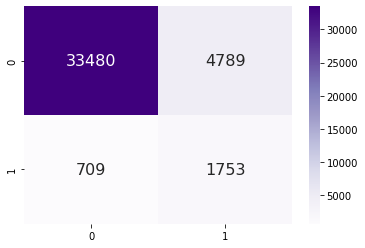

In [ ]:
classification_test(y_test, prediction_class)

### ROC AUC CURVE COMPARISON AND PRECISION-RECALL CURVE COMPARISON

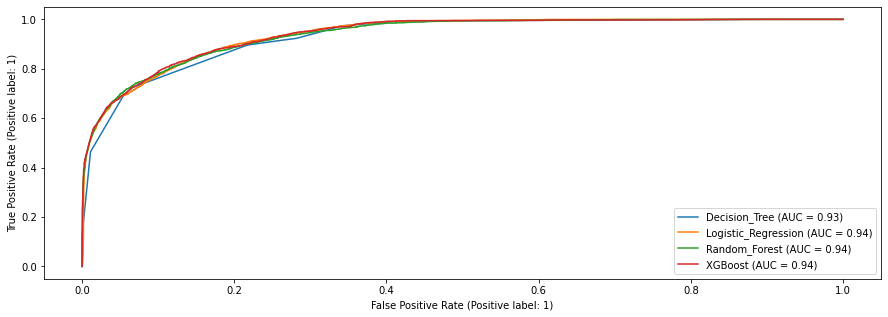

In [ ]:
plt.figure(figsize=[15,5])
classifiers = [results_decision, results_logistic, results_random, results_xgboost]
name = ['Decision_Tree', 'Logistic_Regression', 'Random_Forest', 'XGBoost']
j = 0
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax, name = name[j] )
    j+=1

### DELAY PREDICTION

In [ ]:
train_delay.drop('Cancelled', axis = 1, inplace = True)
test_delay.drop('Cancelled', axis = 1, inplace = True)

In [ ]:
y_train = train_delay.pop('DepDelayFlag')
X_train = train_delay
y_test = test_delay.pop('DepDelayFlag')
X_test = test_delay

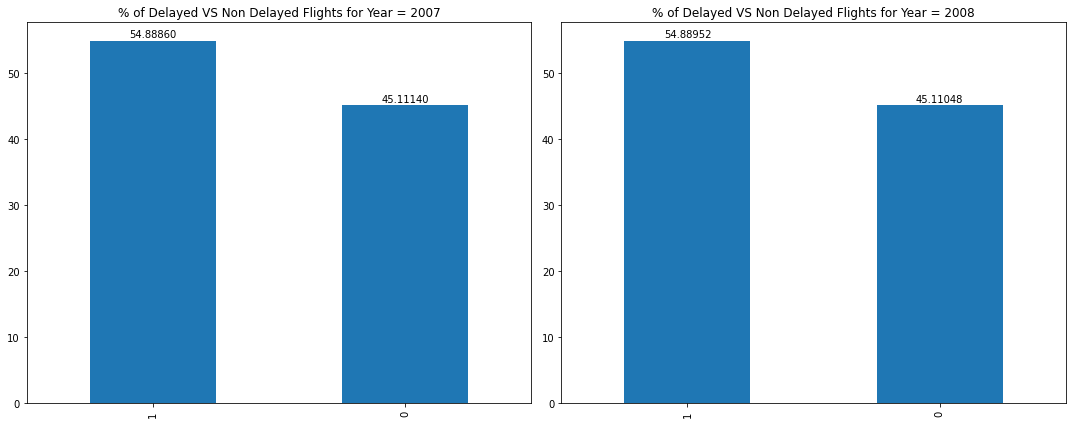

In [ ]:
plt.figure(figsize=[15,6])
plt.subplot(121)
plot_bar = (y_train.value_counts(normalize = True)*100).plot.bar()
for p in plot_bar.patches:
  height = p.get_height()
  plot_bar.text(p.get_x()+p.get_width()/2,height+0.5,'{:1.5f}'.format(height), ha = 'center')
plt.title('% of Delayed VS Non Delayed Flights for Year = 2007')
plt.subplot(122)
plot_bar = (y_test.value_counts(normalize = True)*100).plot.bar()
for p in plot_bar.patches:
  height = p.get_height()
  plot_bar.text(p.get_x()+p.get_width()/2,height+0.5,'{:1.5f}'.format(height), ha = 'center')
plt.title('% of Delayed VS Non Delayed Flights for Year = 2008')
plt.tight_layout()
plt.show()

### Logistic Regression

In [ ]:
### Logistic Regression
%%time
param_grid = {"C": np.arange(0.001, 100, 2), 'penalty':['l1', 'l2']}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

search = GridSearchCV(estimator = LogisticRegression(random_state = 43),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    verbose = 1,
                        return_train_score=True) 
results_logistic = search.fit(X_train, y_train)
print('Config: %s' % results_logistic.best_params_)

In [ ]:
y_test_pred = results_logistic.predict(X_test)
classification_test(y_test, y_test_pred)

### Decision Tree

In [ ]:
%%time
param_grid = {
    'max_depth': [2, 5, 10, 15],
    'min_samples_leaf': [5, 10, 50],
    'min_samples_split': [10, 20],
    'criterion' : ['gini', 'entropy'],
    'max_leaf_nodes': [20, 50, 100]
}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


search = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 43, splitter='random'),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 1,
                        return_train_score=True) 
results_decision = search.fit(X_train, y_train)
print('Config: %s' % results_decision.best_params_)

In [ ]:
y_test_pred = results_decision.predict(X_test)
classification_test(y_test, predictions)

### Random Forest

In [ ]:
%%time
param_grid = {
    'n_estimators': range(30, 100, 20),
    'max_features' : ['auto', 'sqrt', '0.2'],
    'max_depth' : [ 5, 10, 15, 20],
    'min_samples_leaf' : [20, 50, 100]}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)


search = GridSearchCV(estimator = RandomForestClassifier(random_state = 43),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 900,
                        return_train_score=True, n_jobs= -1) 
results_random = search.fit(X_train, y_train)
print('Config: %s' % results_random.best_params_)

In [ ]:
y_test_pred = results_random.predict(X_test)
classification_test(y_test, y_test_pred)

### XGBOOST

In [ ]:
%%time
param_grid = {
    'eta' : [0.01, 0.05, 0.1, 0.2],
    'n_estimators': range(20, 100, 20),
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [ 3, 5, 10] ,
}

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
gpu_dict = {
    'tree_method': 'gpu_hist'
}

search = GridSearchCV(estimator = XGBClassifier(random_state=43, n_jobs=-1, **gpu_dict, reg_alpha = 50),
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = stratified_kfold, 
                        verbose = 1,
                        return_train_score=True) 
results_xgboost = search.fit(X_train, y_train)
print('Config: %s' % results_xgboost.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Config: {'eta': 0.01, 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 20}
CPU times: user 4min 29s, sys: 24.9 s, total: 4min 54s
Wall time: 4min 30s


Accuracy:- 0.8915673761481426
Sensitivity:- 0.8258736559139785
Specificity:- 0.9715021669801293


Classification Report

               precision    recall  f1-score   support

           0       0.82      0.97      0.89     24458
           1       0.97      0.83      0.89     29760

    accuracy                           0.89     54218
   macro avg       0.90      0.90      0.89     54218
weighted avg       0.90      0.89      0.89     54218



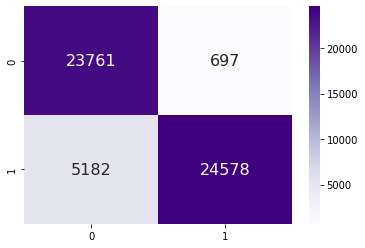

In [ ]:
y_test_pred = results_xgboost.predict(X_test)
classification_test(y_test, y_test_pred)

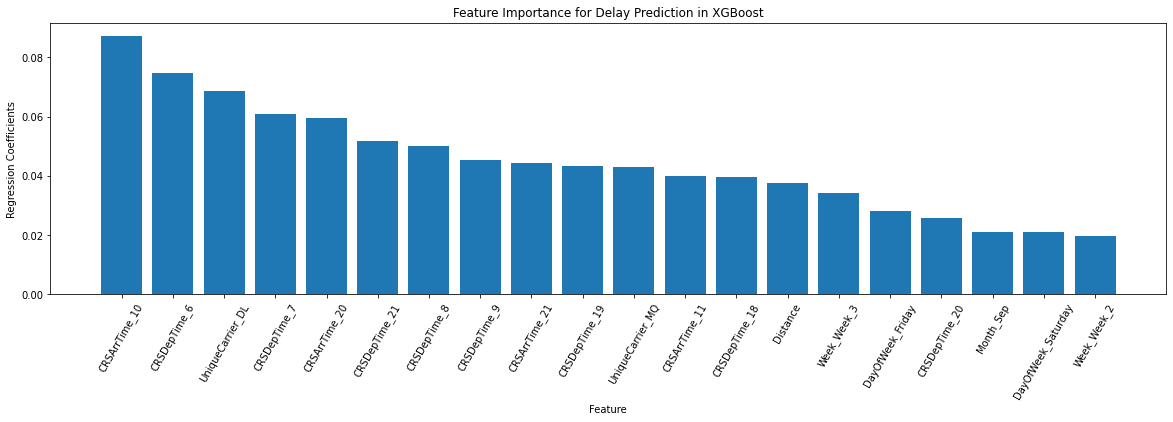

In [ ]:
#Feature Importance
importance = results_xgboost.best_estimator_.feature_importances_
feature_importance = {}
i = 0
for feature in X_train.columns:
  feature_importance[feature] = importance[i]
  i += 1
top_20 = {}
for key in sorted(feature_importance, key=lambda x: feature_importance[x], reverse=True)[:20]:
  top_20[key] = feature_importance[key]

plt.figure(figsize=[20, 5])
plt.bar(top_20.keys(), top_20.values())
plt.xticks(rotation = 60)
plt.title("Feature Importance for Delay Prediction in XGBoost")
plt.xlabel("Feature")
plt.ylabel("Regression Coefficients")
plt.show()

### NEURAL NETWORK

In [ ]:
%%time
model = Sequential()
model.add(Dense(50,input_dim=X_train_smote.shape[1]))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(1))

model.add(Activation('sigmoid'))#sigmoid



model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
model.fit(X_train_smote,y_train_smote,epochs=20)
prediction_prob = model.predict(X_test)

In [ ]:
prediction_class = (prediction_prob > 0.5).astype("int32")

In [ ]:
classification_test(y_test, prediction_class)

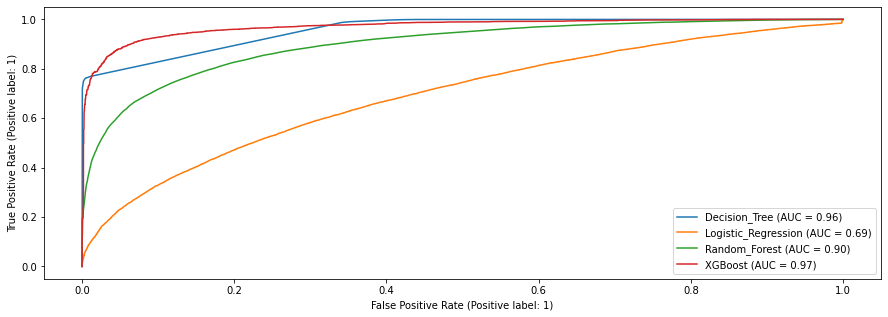

In [ ]:
plt.figure(figsize=[15,5])
classifiers = [results_decision, results_logistic, results_random, results_xgboost]
name = ['Decision_Tree', 'Logistic_Regression', 'Random_Forest', 'XGBoost']
j = 0
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax, name = name[j] )
    j+=1